In [ ]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from pathlib import Path
from sklearn.svm import SVC

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet50 import preprocess_input, ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

After Mounting Drive, Change Current Working Directory to 
**PATH** : '/content/drive/My Drive/Audio Classification with DL'

In [ ]:
os.chdir('drive')
%ls
os.chdir('MyDrive')
%ls

MyDrive/
 13.jpg
 _20171028_225903.jpg
 310426756.pdf
'8 sem.jpg'
 Adhar-converted.pdf
 afpa/
'afpa (1)'/
 Application-UES196M001413.pdf
'authorisation letter.pdf'
 Bamboo/
'B.tech Final Project'/
'caste certificate.jpg'
'Caste Certificate.pdf'
'Caste national.pdf'
 Cer.jpg
 cgpa.pdf
 Cheatsheets/
'Colab Notebooks'/
'Contact Information (1).gform'
'Contact Information (2).gform'
'Contact Information (3).gform'
'Contact Information.gform'
'Contact Information (Responses) (1).gsheet'
'Contact Information (Responses) (2).gsheet'
'Contact Information (Responses).gsheet'
'D109M37A gate application.pdf'
'Deep learning course .pdf'
'Development of HPC and AI centric Computational Methods.pptx'
 Doc1.docx
 Docs/
 domicile.jpg
 FinalFinalFinal.pdf
'FRONT PAGRS PROJECT.docx'
'GIF from Sameer_K'
 gradecard.jpg
'How to get started with Drive.pdf'
'hsc marksheet.jpg'
 hsc.pdf
 iLovePDF/
 IMG_20160901_231054.jpg
 IMG_20160901_231407.jpg
 IMG_20160901_231424.jpg
 IMG_20160901_231437.jpg
 IMG_20160901

In [ ]:
os.chdir("Colab Notebooks")

In [ ]:
os.chdir("Music Genre Classification")

In [ ]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [ ]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [ ]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis] #keep n_mels=128. other values are for experimenting

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [ ]:
def split_convert(X, y):
    arr_spec, arr_genre = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in tqdm(zip(X, y),total=len(y),desc='Processing Audio Files'):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre, window=0.05) #keep window=0.05. Other values are for experimenting. 

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genre.extend(y)
        arr_spec.extend(specs)
    
    return np.array(arr_spec), to_categorical(arr_genre)

In [ ]:
def read_data(src_dir, genres, song_samples,get_data='train'):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    if get_data=='train':
        for x,_ in genres.items():
            folder = src_dir+'/'+'train'+'/' + x
            for root, subdirs, files in os.walk(folder):
                print(root)
                for file in files:
                    file_name = folder + "/" + file
#                     print(file_name)
                    # Save the file name and the genre
                    arr_fn.append(file_name)
                    
                    arr_genres.append(genres[x])
                
        # print(len(arr_fn))
        # print(len(arr_genres))
        # print()
        # Split into small segments and convert to spectrogram
        X_train, y_train = split_convert(arr_fn, arr_genres)
        return X_train, y_train
    
    elif get_data=='test':
        folder = src_dir+'/'+'test'
        for root, subdirs, files in os.walk(folder):
            for idx,file in enumerate(files):
                file_name = folder + "/" + file
                print(idx)
                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(idx//10)
    
        X_test, y_test = split_convert(arr_fn, arr_genres)
        return X_test, y_test
    else:
        #print('Specify "test" or "train"')
        return None,None

In [ ]:
%ls

 AudioClassification.py           models/
 audio_data_visualization.ipynb   test_data.csv
 AudioSpectrum.ipynb              train_classical_ml_models.ipynb
'CNN_train(1).ipynb'              train_data.csv
 genres/                          Untitled.ipynb
 make_dataset_ml.py


In [ ]:
# Parameters

gtzan_dir = 'genres'
song_samples = 660000
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, y_train = read_data(gtzan_dir, genres, song_samples,get_data='train')
X_test, y_test = read_data(gtzan_dir, genres, song_samples,get_data='test')

Processing Audio Files:   0%|          | 0/900 [00:00<?, ?it/s]

genres/train/blues
genres/train/classical
genres/train/country
genres/train/disco
genres/train/hiphop
genres/train/jazz
genres/train/metal
genres/train/pop
genres/train/reggae
genres/train/rock


Processing Audio Files:   0%|          | 0/100 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Processing Audio Files: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test)

(35100, 128, 129, 1) (3900, 128, 129, 1) (35100, 10) (3900, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


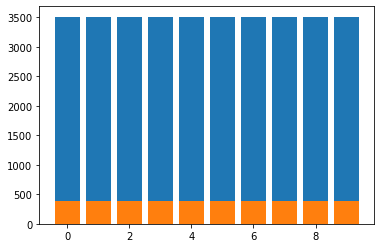

In [ ]:
 # Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# GTZAN Melspectrogram Generator

In [ ]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=2)
                cols = np.random.randint(signal.shape[0], size=3)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# Custom CNN (Melspectrogram version)

In [ ]:
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = Dropout(0.4)(x)
    return x

In [ ]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16,stride=(2,2))
    x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 64, stride=(2,2))
    x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 256,stride=(2,2))

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [ ]:
print(X_train.shape)

(35100, 128, 129, 1)


In [ ]:
model = create_model(X_train[0].shape, 10)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 129, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 129, 16)      160       
_________________________________________________________________
activation_9 (Activation)    (None, 128, 129, 16)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 32)        0     

### Loss function

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

In [ ]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=500,
    verbose=1,
    callbacks=[reduceLROnPlat])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
275/275 [==============================] - 39s 26ms/step - loss: 5.6483 - accuracy: 0.1018 - val_loss: 4.0136 - val_accuracy: 0.1794
Epoch 2/500
275/275 [==============================] - 7s 26ms/step - loss: 3.6207 - accuracy: 0.1529 - val_loss: 3.3610 - val_accuracy: 0.1966
Epoch 3/500
275/275 [==============================] - 7s 25ms/step - loss: 3.0466 - accuracy: 0.1756 - val_loss: 2.9853 - val_accuracy: 0.2087
Epoch 4/500
275/275 [==============================] - 7s 25ms/step - loss: 2.7473 - accuracy: 0.1775 - val_loss: 2.7403 - val_accuracy: 0.2162
Epoch 5/500
275/275 [==============================] - 7s 25ms/step - loss: 2.5386 - accuracy: 0.1815 - val_loss: 2.5627 - val_accuracy: 0.2167
Epoch 6/500
275/275 [==============================] - 7s 25ms/step - loss: 2.3784 - accuracy: 0.2122 - val_loss: 2.4365 - val_accuracy: 0.2460
Epoch 7/500
275/275 [==============================] - 7s 25ms/step - loss: 2.2637 - accuracy: 0.2128 - val_loss: 2.1546 - val_accuracy

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.008 and val_acc = 0.673


In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


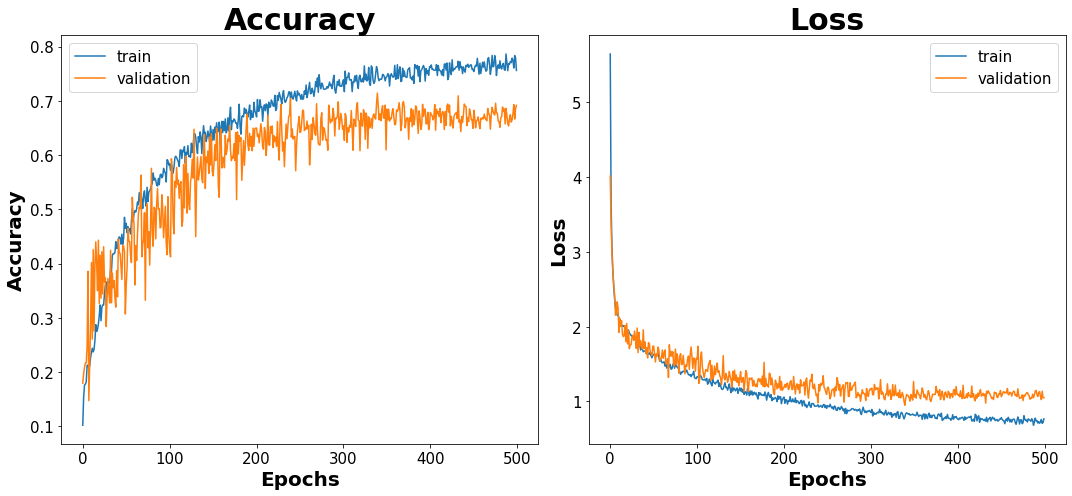

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy',fontsize=30,fontweight="bold")
plt.xlabel('Epochs',fontsize=20,fontweight="bold")
plt.ylabel('Accuracy',fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss',fontsize=30,fontweight="bold")
plt.xlabel('Epochs',fontsize=20,fontweight="bold")
plt.ylabel('Loss',fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30,fontweight="bold")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20,fontweight="bold")
    plt.xlabel('Predicted label',fontsize=20,fontweight="bold")

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


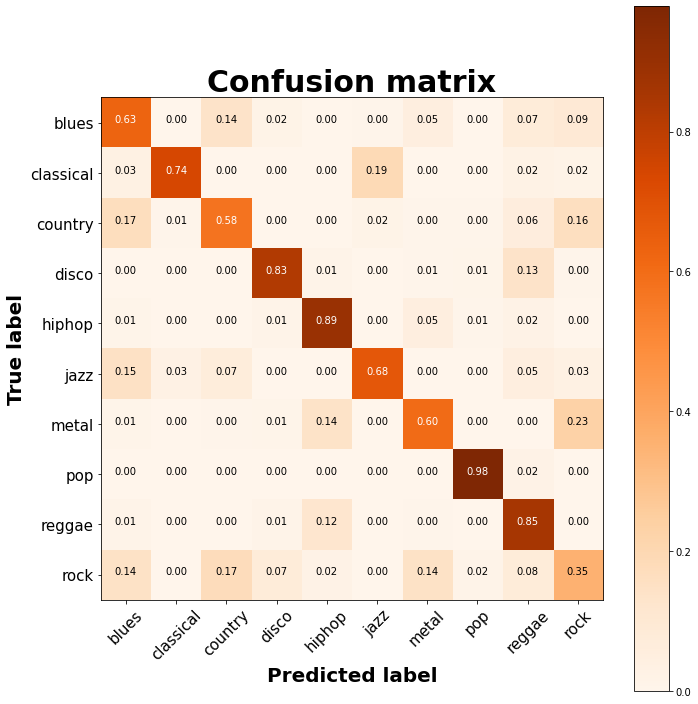

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

### SVM

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgbm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

In [ ]:
df=pd.read_csv('train_data.csv')
df_t=pd.read_csv('test_data.csv')
print(df_t.head())
df.head()
X_train=df.drop('label',axis=1).values
y_train=df['label'].values
print(X_train.shape)
print(y_train.shape)
X_test=df_t.drop('label',axis=1).values
y_test=df_t['label'].values
print(X_test.shape)
print(y_test.shape)

   centroid_max  centroid_min  centroid_mean  centroid_std  centroid_kurtosis  \
0   5820.641540    261.040213    1489.099451    869.563705           3.616855   
1   4162.982445    222.777126     910.093663    617.512284           5.668595   
2   5473.726906    201.631743     846.608476    696.522263          12.843469   
3   4152.928614    228.475668     533.912001    292.272569          81.652454   
4   4100.772671    258.071118    1172.629536    719.401491          -0.074815   

   centroid_skew   flux_max  flux_min  flux_mean  flux_std  ...  \
0       1.591652  14.850361       0.0   1.520827  1.826153  ...   
1       2.222877  22.074821       0.0   1.542874  2.485558  ...   
2       3.163414   9.720446       0.0   1.176664  1.500442  ...   
3       8.014757  18.117476       0.0   0.813941  1.358511  ...   
4       0.839901  12.749510       0.0   1.239240  1.326141  ...   

   mfcc_18_kurtosis  mfcc_18_skew  mfcc_19_max  mfcc_19_min  mfcc_19_mean  \
0         -0.221447      0.104325

In [ ]:
params = {
    "cls__C": [0.5, 1, 5, 10],
    "cls__kernel": ['rbf', 'sigmoid','poly'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=0.1)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=-1,verbose=2)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.1)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=-1,
             param_grid={'cls__C': [0.5, 1, 5, 10],
                         'cls__kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='accuracy', verbose=2)

In [ ]:
preds = grid_svm.predict(X_test)
print("Best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("Best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

Best score on validation set (accuracy) = 0.6678
Best score on test set (accuracy) = 0.7600
